<a href="https://colab.research.google.com/github/joshdasquash/6289midterm/blob/main/tesla_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

A significant portion of my full-time job as a data engineer involves time series analysis and working with time series data at the Federal Reserve Board. Some of the instructions in the homework were confusing and or not clear; thus, I may be deviating in small ways in how I interpret mid-steps. However, I will always justify my reasoning and steps and make sure I provide the sufficient results.

Overall, I build an LSTM model and operate it on TSLA stock data (with a 14-day lagged window from which I forecast the next value). The main comparisons of interest include:


1.   Hidden layers: I test 2, 4, 6, and 8 hidden layers.
2.   Dropout: I test 0, 0.25, and 0.5 dropout on the 4 hidden layer case.

Finally, after applying the model on the training, validation, and test data sets, I forecast two weeks into the future using a recursive daily forecast. It does not make much sense to me to forecast two weeks of data ahead because to do so would require you to "overwrite" past forecasts or to not gradually "window" forecast. So, I forecast day-by-day, and interpret two weeks of forecasts by recursively applying day-by-day forecasting over a period of two weeks.

# Preparations and Data Transformation

First we load the necessary libraries.

In [3]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import datetime

We import the date, select the Date and Close columns, apply a conversion to the Date column, and make it an index (temporarily).

In [4]:
# function to help us convert date strings in csv to datetime
def dateconv(s):
  split = s.split('/')
  year, month, day = int(split[2]), int(split[0]), int(split[1])
  return datetime.datetime(year=year, month=month, day=day)

In [5]:
df= pd.read_csv("TSLA.csv")
df = df[["Date", "Close"]]
df['Date'] = df['Date'].apply(dateconv)
df.index = df.pop('Date')

In [6]:
df

,Close
Date,
2015-07-10,51.830002
2015-07-13,52.431999
2015-07-14,53.130001
2015-07-15,52.627998
2015-07-16,53.335999
...,...
2020-07-02,241.731995
2020-07-06,274.316010
2020-07-07,277.971985


Now, we plot the data.

Text(0, 0.5, 'Closing Price')

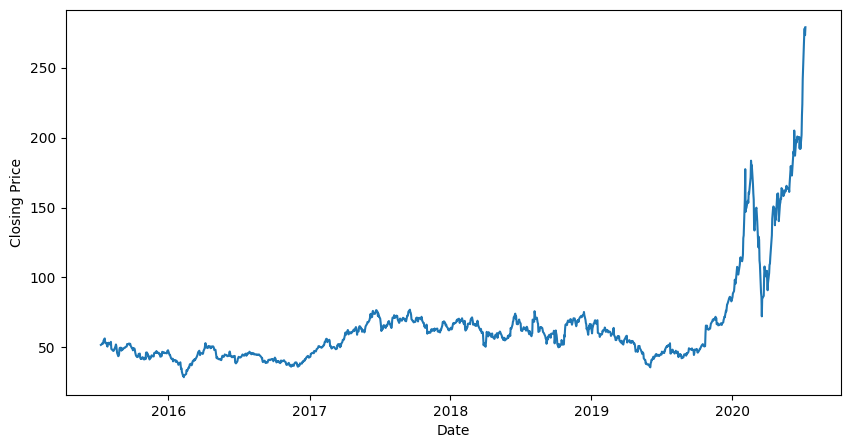

In [11]:
plt.figure(figsize = (10, 5))
plt.plot(df.index, df['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price')

Next, we create a windowed / lagged dataframe with Date (of the Closing Price), Close, and the Close of the previous 14 days. This will give us the window that we use to filter the next date, which includes 14 different lags (including all that were specified in the homework, plus additional).

In [12]:
lags = range(1,15)
cols = list("Close")

df_lag = df.assign(**{
    f'{col} (t-{lag})': df[col].shift(lag)
    for lag in lags
    for col in df
})

df_lag = df_lag.reset_index()
df_lag = df_lag.dropna()


In [13]:
df_lag

,Date,Close,Close (t-1),Close (t-2),Close (t-3),Close (t-4),Close (t-5),Close (t-6),Close (t-7),Close (t-8),Close (t-9),Close (t-10),Close (t-11),Close (t-12),Close (t-13),Close (t-14)
14,2015-07-30,53.358002,52.764000,52.964001,50.602001,53.082001,53.439999,53.574001,53.354000,56.452000,54.931999,53.335999,52.627998,53.130001,52.431999,51.830002
15,2015-07-31,53.230000,53.358002,52.764000,52.964001,50.602001,53.082001,53.439999,53.574001,53.354000,56.452000,54.931999,53.335999,52.627998,53.130001,52.431999
16,2015-08-03,51.998001,53.230000,53.358002,52.764000,52.964001,50.602001,53.082001,53.439999,53.574001,53.354000,56.452000,54.931999,53.335999,52.627998,53.130001
17,2015-08-04,53.256001,51.998001,53.230000,53.358002,52.764000,52.964001,50.602001,53.082001,53.439999,53.574001,53.354000,56.452000,54.931999,53.335999,52.627998
18,2015-08-05,54.026001,53.256001,51.998001,53.230000,53.358002,52.764000,52.964001,50.602001,53.082001,53.439999,53.574001,53.354000,56.452000,54.931999,53.335999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2020-07-02,241.731995,223.925995,215.962006,201.869995,191.947998,197.195999,192.169998,200.356003,198.863998,200.179993,200.792007,198.358002,196.425995,198.179993,187.056000
1255,2020-07-06,274.316010,241.731995,223.925995,215.962006,201.869995,191.947998,197.195999,192.169998,200.356003,198.863998,200.179993,200.792007,198.358002,196.425995,198.179993
1256,2020-07-07,277.971985,274.316010,241.731995,223.925995,215.962006,201.869995,191.947998,197.195999,192.169998,200.356003,198.863998,200.179993,200.792007,198.358002,196.425995
1257,2020-07-08,273.175995,277.971985,274.316010,241.731995,223.925995,215.962006,201.869995,191.947998,197.195999,192.169998,200.356003,198.863998,200.179993,200.792007,198.358002


This function is used to convert items into the right type and dimensions for our model analysis.

In [14]:
def tf_df_lag(df):
  df_as_np = df.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = tf_df_lag(df_lag)

dates.shape, X.shape, y.shape

((1245,), (1245, 14, 1), (1245,))

Now, we split the data into training, validation, and test data, using a roughly 60/20/20 split. We note that the test data set is significantly more volatile than the training and validation data sets, which may cause difficulty for our future predictions.

Text(0, 0.5, 'Closing Price')

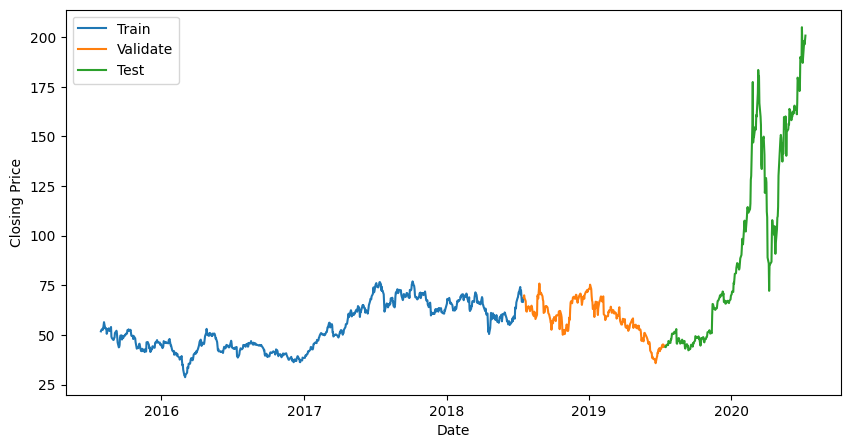

In [16]:
q_60 = int(len(dates) * 0.6)
q_80 = int(len(dates) * 0.8)

dates_train, X_train, y_train = dates[:q_60], X[:q_60], y[:q_60]
dates_val, X_val, y_val = dates[q_60:q_80], X[q_60:q_80], y[q_60:q_80]
dates_test, X_test, y_test = dates[q_80:], X[q_80:], y[q_80:]

plt.figure(figsize = (10, 5))
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train','Validate','Test'])
plt.xlabel('Date')
plt.ylabel('Closing Price')

# Impact of Hidden Layers

In this section, we analyze the impact of varying the number of hidden layers. We design similar LSTM models tailored to the input size which only differ by the number of hidden layers they possess. We use an Adam optimizer with loss given by mean squared error, while also tracking mean absolute error.

## Model Design

In [ ]:
# MODEL: 2 layers
model_2L = Sequential([layers.Input((14, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model_2L.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model_2L.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

In [ ]:
# MODEL: 4 layers
model_4L = Sequential([layers.Input((14, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model_4L.compile(loss='mse',
                 optimizer=Adam(learning_rate=0.001),
                 metrics=['mean_absolute_error'])

model_4L.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

In [ ]:
# MODEL: 6 layers
model_6L = Sequential([layers.Input((14, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model_6L.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model_6L.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

In [ ]:
# MODEL: 8 layers
model_8L = Sequential([layers.Input((14, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model_8L.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model_8L.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

## Model evaluation

For both the training and validation section, we see that the results are very close. All models perform quite well. This is evident by looking at error.

In [21]:
model_2L.evaluate(X_train, y_train), model_4L.evaluate(X_train, y_train), model_6L.evaluate(X_train, y_train), model_8L.evaluate(X_train, y_train)

24/24 [==============================] - 0s 5ms/step - loss: 1.9372 - mean_absolute_error: 1.0493


([1.9775989055633545, 1.048262357711792],
 [1.9877418279647827, 1.0578904151916504],
 [1.8500416278839111, 1.0113276243209839],
 [1.9372336864471436, 1.0493372678756714])

In [22]:
model_2L.evaluate(X_val, y_val), model_4L.evaluate(X_val, y_val), model_6L.evaluate(X_val, y_val), model_8L.evaluate(X_val, y_val)

8/8 [==============================] - 0s 4ms/step - loss: 4.8565 - mean_absolute_error: 1.5010


([5.103734016418457, 1.5853853225708008],
 [4.936743259429932, 1.519046425819397],
 [4.850850582122803, 1.5017049312591553],
 [4.856522560119629, 1.5009770393371582])

And it is easier to see how close the various models are by visualizing.

24/24 [==============================] - 0s 3ms/step


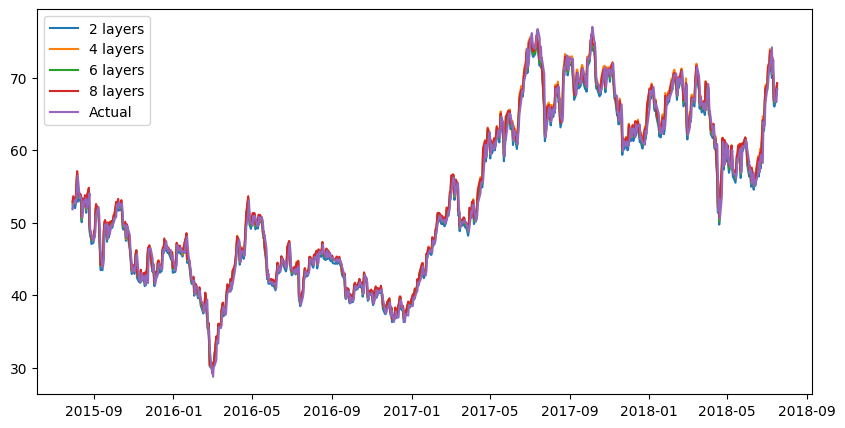

In [23]:
train_pred_2L = model_2L.predict(X_train).flatten()
train_pred_4L = model_4L.predict(X_train).flatten()
train_pred_6L = model_6L.predict(X_train).flatten()
train_pred_8L = model_8L.predict(X_train).flatten()

plt.figure(figsize = (10, 5))
plt.plot(dates_train, train_pred_2L)
plt.plot(dates_train, train_pred_4L)
plt.plot(dates_train, train_pred_6L)
plt.plot(dates_train, train_pred_8L)
plt.plot(dates_train, y_train)
plt.legend(['2 layers',
            '4 layers',
            '6 layers',
            '8 layers',
            'Actual'])

8/8 [==============================] - 0s 3ms/step


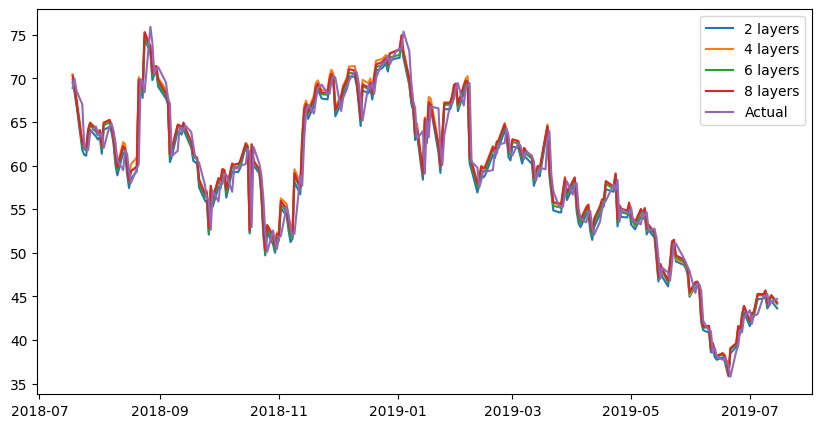

In [24]:
val_pred_2L = model_2L.predict(X_val).flatten()
val_pred_4L = model_4L.predict(X_val).flatten()
val_pred_6L = model_6L.predict(X_val).flatten()
val_pred_8L = model_8L.predict(X_val).flatten()

plt.figure(figsize = (10, 5))
plt.plot(dates_val, val_pred_2L)
plt.plot(dates_val, val_pred_4L)
plt.plot(dates_val, val_pred_6L)
plt.plot(dates_val, val_pred_8L)
plt.plot(dates_val, y_val)
plt.legend(['2 layers',
            '4 layers',
            '6 layers',
            '8 layers',
            'Actual'])

The real differentiation comes in the evaluation of the test data. For the beginning of the test data, our model performs extremely well. But once we hit greatvolatility, we see that the 8-layer case is the most successful in dealing with the volatility, followed by the 6-layer case.

Yes, there is significant difference between observed and predicted values; however, such a spike has never been incorporated in the training data so the ability for the model to take such a massive spike and drop into account is limited.

Additional layers improve the ability of the LSTM model to forecast in difficult scenarios.

8/8 [==============================] - 1s 209ms/step


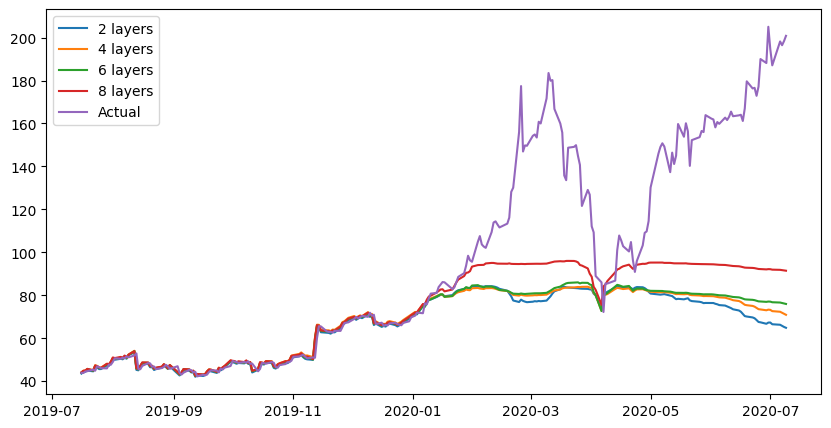

In [62]:
test_pred_2L = model_2L.predict(X_test).flatten()
test_pred_4L = model_4L.predict(X_test).flatten()
test_pred_6L = model_6L.predict(X_test).flatten()
test_pred_8L = model_8L.predict(X_test).flatten()

plt.figure(figsize = (10, 5))
plt.plot(dates_test, test_pred_2L)
plt.plot(dates_test, test_pred_4L)
plt.plot(dates_test, test_pred_6L)
plt.plot(dates_test, test_pred_8L)
plt.plot(dates_test, y_test)
plt.legend(['2 layers',
            '4 layers',
            '6 layers',
            '8 layers',
            'Actual'])

## Model Forecasting

For the forecasting portion of the exercise (i.e. not relying on purely historical data for the forecast), I opt to recursively forecast for a two-week period following the validation training set because of the volatility of the testing space. If I were to forecast following the volatility, I would want to incorporate the entire portion into my training of the model.

In this next portion, we actually forecast ahead, using the last window of the training data set, the next 14 days of closing data. We conduct this process recursively. We opt to use the actual last window of data (as opposed to the predicted last window) because this is the true way one would forecast.

Letting the range of the loop be (1,2), (1,8), and (1,15) give 1 day, 7 day, and 14 day predictions, respectively. The results of the latter cases encapsulate the former results, so setting the range to (1,15) in the loop is sufficient to obtain the 1 day, 1 week, and 2 week forecast predictions.

In [ ]:
last_window_2L = X_train[-1]
last_window_4L = X_train[-1]
last_window_6L = X_train[-1]
last_window_8L = X_train[-1]

for i in range(1,15):
  next_pred_2L = model_2L.predict(np.array([last_window_2L]))
  next_pred_4L = model_4L.predict(np.array([last_window_4L]))
  next_pred_6L = model_6L.predict(np.array([last_window_6L]))
  next_pred_8L = model_8L.predict(np.array([last_window_8L]))
  last_window_2L = np.append(last_window_2L, next_pred_2L, axis = 0)
  last_window_2L = np.delete(last_window_2L, 0, axis=0)
  last_window_4L = np.append(last_window_4L, next_pred_4L, axis = 0)
  last_window_4L = np.delete(last_window_4L, 0, axis=0)
  last_window_6L = np.append(last_window_6L, next_pred_6L, axis = 0)
  last_window_6L = np.delete(last_window_6L, 0, axis=0)
  last_window_8L = np.append(last_window_8L, next_pred_8L, axis = 0)
  last_window_8L = np.delete(last_window_8L, 0, axis=0)

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
US_BUSINESS_DAY = CustomBusinessDay(calendar=USFederalHolidayCalendar())

forecast14list = [dates_train[-1]+US_BUSINESS_DAY*x for x in range(1,15)]
forecast14list = np.array(forecast14list)


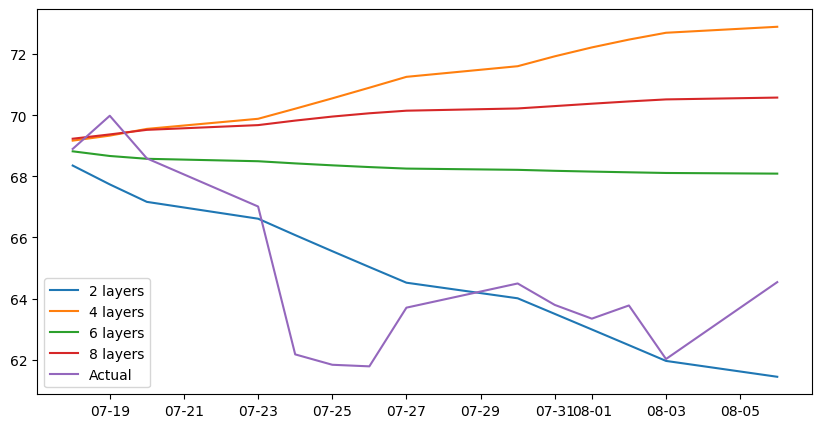

In [75]:
import matplotlib.dates as mdates

plt.figure(figsize = (10, 5))
plt.plot(forecast14list, last_window_2L.flatten())
plt.plot(forecast14list, last_window_4L.flatten())
plt.plot(forecast14list, last_window_6L.flatten())
plt.plot(forecast14list, last_window_8L.flatten())
plt.plot(forecast14list, y_val[0:14]) # because it's 14 after the test, which is val

myFmt = mdates.DateFormatter('%m-%d')
plt.gca().xaxis.set_major_formatter(myFmt)

plt.legend(['2 layers',
            '4 layers',
            '6 layers',
            '8 layers',
            'Actual'])

In this short term analysis, 2 layer looks superior. We then reapply the same analysis following the validation data set.

In [ ]:
last_window_2L = X_val[-1]
last_window_4L = X_val[-1]
last_window_6L = X_val[-1]
last_window_8L = X_val[-1]

for i in range(1,15):
  next_pred_2L = model_2L.predict(np.array([last_window_2L]))
  next_pred_4L = model_4L.predict(np.array([last_window_4L]))
  next_pred_6L = model_6L.predict(np.array([last_window_6L]))
  next_pred_8L = model_8L.predict(np.array([last_window_8L]))
  last_window_2L = np.append(last_window_2L, next_pred_2L, axis = 0)
  last_window_2L = np.delete(last_window_2L, 0, axis=0)
  last_window_4L = np.append(last_window_4L, next_pred_4L, axis = 0)
  last_window_4L = np.delete(last_window_4L, 0, axis=0)
  last_window_6L = np.append(last_window_6L, next_pred_6L, axis = 0)
  last_window_6L = np.delete(last_window_6L, 0, axis=0)
  last_window_8L = np.append(last_window_8L, next_pred_8L, axis = 0)
  last_window_8L = np.delete(last_window_8L, 0, axis=0)

In this case, 8 layers performed the best (see the below computation). What matters though is the long-run outcome as shown above in the previous portion. The 8-layer model provides the best long-term predictive power (though some other models may provide better cases over the short run).

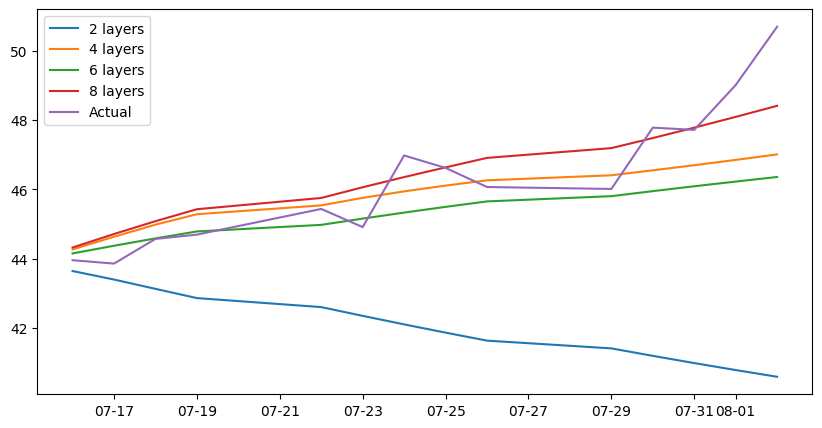

In [102]:
forecast14list = [dates_val[-1]+US_BUSINESS_DAY*x for x in range(1,15)]
forecast14list = np.array(forecast14list)

plt.figure(figsize = (10, 5))
plt.plot(forecast14list, last_window_2L.flatten())
plt.plot(forecast14list, last_window_4L.flatten())
plt.plot(forecast14list, last_window_6L.flatten())
plt.plot(forecast14list, last_window_8L.flatten())
plt.plot(forecast14list, y_test[0:14])

myFmt = mdates.DateFormatter('%m-%d')
plt.gca().xaxis.set_major_formatter(myFmt)

plt.legend(['2 layers',
            '4 layers',
            '6 layers',
            '8 layers',
            'Actual'])

In [107]:
sum((last_window_2L.flatten() - y_test[0:14])**2),sum((last_window_4L.flatten() - y_test[0:14])**2), sum((last_window_6L.flatten() - y_test[0:14])**2),sum((last_window_8L.flatten() - y_test[0:14])**2)

(367.0848014652729, 24.336275916546583, 37.468961088510696, 11.745902574679349)

# Impact of Dropout

Now, we consider the impact of dropout on our forecasting. We use three different dropout models, each with a 4 hidden layer LSTM setup.

In [ ]:
model_D0 = Sequential([layers.Input((14, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    Dropout(0),
                    layers.Dense(32, activation='relu'),
                    Dropout(0),
                    layers.Dense(32, activation='relu'),
                    Dropout(0),
                    layers.Dense(32, activation='relu'),
                    Dropout(0),
                    layers.Dense(1)])

model_D0.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model_D0.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

In [ ]:
model_D25 = Sequential([layers.Input((14, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    Dropout(0.25),
                    layers.Dense(32, activation='relu'),
                    Dropout(0.25),
                    layers.Dense(32, activation='relu'),
                    Dropout(0.25),
                    layers.Dense(32, activation='relu'),
                    Dropout(0.25),
                    layers.Dense(1)])

model_D25.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model_D25.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

In [ ]:
model_D50 = Sequential([layers.Input((14, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    Dropout(0.5),
                    layers.Dense(32, activation='relu'),
                    Dropout(0.5),
                    layers.Dense(32, activation='relu'),
                    Dropout(0.5),
                    layers.Dense(32, activation='relu'),
                    Dropout(0.5),
                    layers.Dense(1)])

model_D50.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model_D50.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

As seen below, the no-dropout model has the best performance in training and validation. However, the 0.25 dropout model has the best performance in the more volatile testing environment.

In [84]:
model_D0.evaluate(X_train, y_train), model_D25.evaluate(X_train, y_train), model_D50.evaluate(X_train, y_train)

24/24 [==============================] - 0s 20ms/step - loss: 48.5165 - mean_absolute_error: 5.6664


([2.092532157897949, 1.089913010597229],
 [15.20789909362793, 2.9957356452941895],
 [48.516502380371094, 5.666444301605225])

In [85]:
model_D0.evaluate(X_val, y_val), model_D25.evaluate(X_val, y_val), model_D50.evaluate(X_val, y_val)

8/8 [==============================] - 0s 53ms/step - loss: 73.2335 - mean_absolute_error: 7.8275


([5.226946830749512, 1.615446925163269],
 [22.07049560546875, 4.033242702484131],
 [73.2334976196289, 7.827549457550049])

24/24 [==============================] - 2s 65ms/step


Text(0.5, 1.0, 'Training')

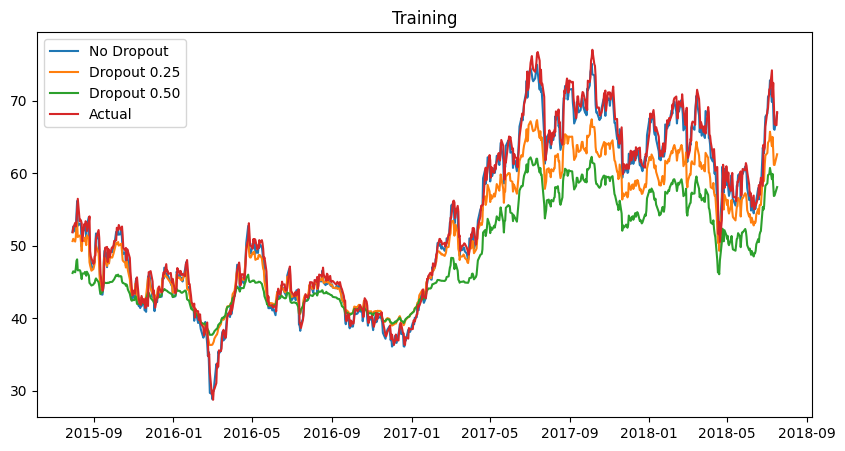

In [93]:
train_pred_D0 = model_D0.predict(X_train).flatten()
train_pred_D25 = model_D25.predict(X_train).flatten()
train_pred_D50 = model_D50.predict(X_train).flatten()

plt.figure(figsize = (10, 5))
plt.plot(dates_train, train_pred_D0)
plt.plot(dates_train, train_pred_D25)
plt.plot(dates_train, train_pred_D50)
plt.plot(dates_train, y_train)
plt.legend(['No Dropout',
            'Dropout 0.25',
            'Dropout 0.50',
            'Actual'])
plt.title("Training")

8/8 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Validation')

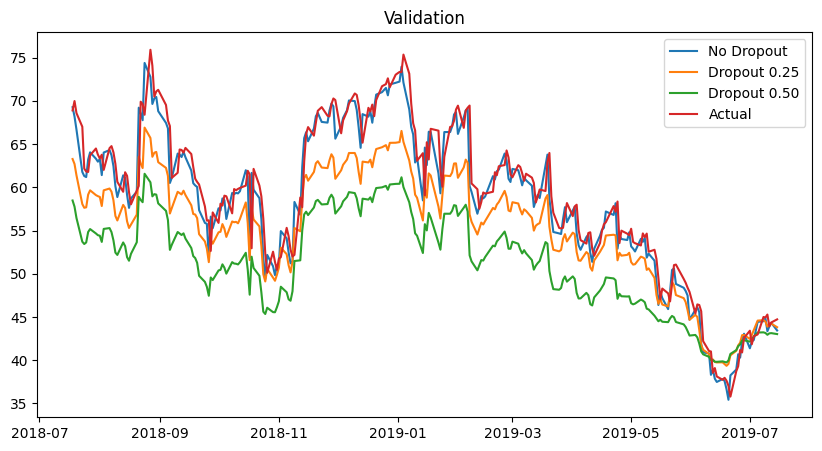

In [96]:
val_pred_D0 = model_D0.predict(X_val).flatten()
val_pred_D25 = model_D25.predict(X_val).flatten()
val_pred_D50 = model_D50.predict(X_val).flatten()

plt.figure(figsize = (10, 5))
plt.plot(dates_val, val_pred_D0)
plt.plot(dates_val, val_pred_D25)
plt.plot(dates_val, val_pred_D50)
plt.plot(dates_val, y_val)
plt.legend(['No Dropout',
            'Dropout 0.25',
            'Dropout 0.50',
            'Actual'])
plt.title('Validation')

8/8 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Testing')

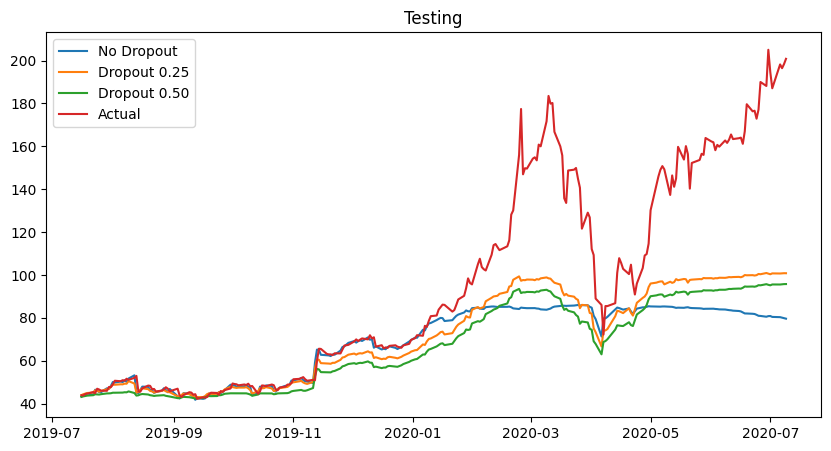

In [97]:
test_pred_D0 = model_D0.predict(X_test).flatten()
test_pred_D25 = model_D25.predict(X_test).flatten()
test_pred_D50 = model_D50.predict(X_test).flatten()

plt.figure(figsize = (10, 5))
plt.plot(dates_test, test_pred_D0)
plt.plot(dates_test, test_pred_D25)
plt.plot(dates_test, test_pred_D50)
plt.plot(dates_test, y_test)
plt.legend(['No Dropout',
            'Dropout 0.25',
            'Dropout 0.50',
            'Actual'])
plt.title('Testing')

In the training environment, no-dropout performs best. But in the test environment, 0.25 dropout performs best.

In [98]:
sum((train_pred_D0 - y_train)**2), sum((train_pred_D25 - y_train)**2), sum((train_pred_D50 - y_train)**2)

(1563.1216204792727, 11360.299614780699, 36241.83236019025)

In [99]:
sum((test_pred_D0 - y_test)**2), sum((test_pred_D25 - y_test)**2), sum((test_pred_D50 - y_test)**2)

(489874.59101078426, 341051.52216364583, 413656.53157960065)

## Model Forecasting

Finally, we conclude with a repeat of the forecasting exercise, this time concerning dropout and following the training data.

In [ ]:
last_window_D0 = X_train[-1]
last_window_D25 = X_train[-1]
last_window_D50 = X_train[-1]

for i in range(1,15):
  next_pred_D0 = model_D0.predict(np.array([last_window_D0]))
  next_pred_D25 = model_D25.predict(np.array([last_window_D25]))
  next_pred_D50 = model_D50.predict(np.array([last_window_D50]))
  last_window_D0 = np.append(last_window_D0, next_pred_D0, axis = 0)
  last_window_D0 = np.delete(last_window_D0, 0, axis=0)
  last_window_D25 = np.append(last_window_D25, next_pred_D25, axis = 0)
  last_window_D25 = np.delete(last_window_D25, 0, axis=0)
  last_window_D50 = np.append(last_window_D50, next_pred_D50, axis = 0)
  last_window_D50 = np.delete(last_window_D50, 0, axis=0)

forecast14list = [dates_train[-1]+US_BUSINESS_DAY*x for x in range(1,15)]
forecast14list = np.array(forecast14list)


Text(0.5, 1.0, 'Post-Training Forecast')

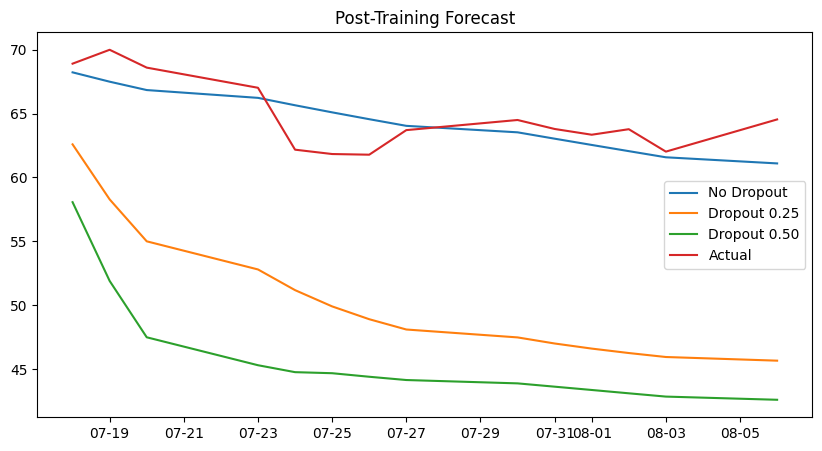

In [127]:
plt.figure(figsize = (10, 5))
plt.plot(forecast14list, last_window_D0.flatten())
plt.plot(forecast14list, last_window_D25.flatten())
plt.plot(forecast14list, last_window_D50.flatten())
plt.plot(forecast14list, y_val[0:14]) # because it's 14 after the test, which is val

myFmt = mdates.DateFormatter('%m-%d')
plt.gca().xaxis.set_major_formatter(myFmt)

plt.legend(['No Dropout',
            'Dropout 0.25',
            'Dropout 0.50',
            'Actual'])
plt.title('Post-Training Forecast')

We see that the No Dropout case performed the best. On the validation, we repeat and find 0.25 performed the best, followed by No Dropout.

In [ ]:
last_window_D0 = X_val[-1]
last_window_D25 = X_val[-1]
last_window_D50 = X_val[-1]

for i in range(1,15):
  next_pred_D0 = model_D0.predict(np.array([last_window_D0]))
  next_pred_D25 = model_D25.predict(np.array([last_window_D25]))
  next_pred_D50 = model_D50.predict(np.array([last_window_D50]))
  last_window_D0 = np.append(last_window_D0, next_pred_D0, axis = 0)
  last_window_D0 = np.delete(last_window_D0, 0, axis=0)
  last_window_D25 = np.append(last_window_D25, next_pred_D25, axis = 0)
  last_window_D25 = np.delete(last_window_D25, 0, axis=0)
  last_window_D50 = np.append(last_window_D50, next_pred_D50, axis = 0)
  last_window_D50 = np.delete(last_window_D50, 0, axis=0)

forecast14list = [dates_val[-1]+US_BUSINESS_DAY*x for x in range(1,15)]
forecast14list = np.array(forecast14list)


Text(0.5, 1.0, 'Post-Validation Forecast')

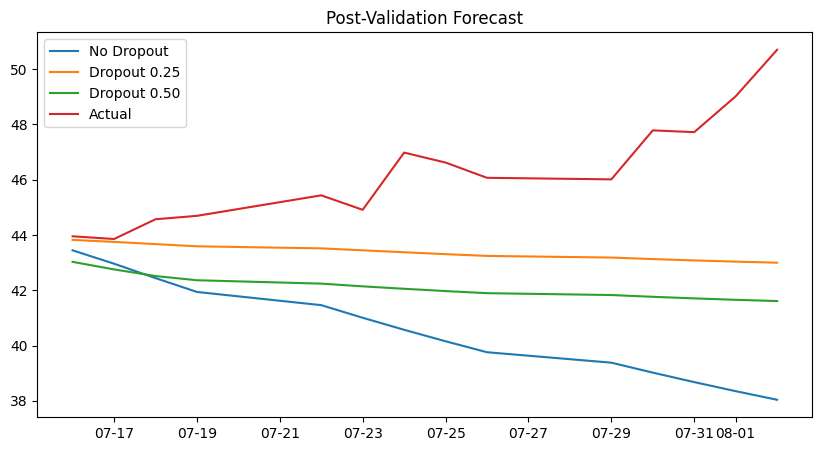

In [129]:
plt.figure(figsize = (10, 5))
plt.plot(forecast14list, last_window_D0.flatten())
plt.plot(forecast14list, last_window_D25.flatten())
plt.plot(forecast14list, last_window_D50.flatten())
plt.plot(forecast14list, y_test[0:14]) # because it's 14 after the test, which is val

myFmt = mdates.DateFormatter('%m-%d')
plt.gca().xaxis.set_major_formatter(myFmt)

plt.legend(['No Dropout',
            'Dropout 0.25',
            'Dropout 0.50',
            'Actual'])
plt.title('Post-Validation Forecast')